## Section F: Logistic Regression vs. Bayesian Classifier
This task assesses your analytical skills. You need to study the performance of
two well-known generative and discriminative models, i.e. Bayesian classifier
and logistic regression, as the size of the training set increases. 

### Question 7: Discriminative vs Generative Models
> ##### 1. Load Task1E_train.csv and Task1E_test.csv as well as the Bayesian classifier (BC) and logistic regression (LR) codes 

In [33]:
#installing packages for melting and ploting 
options(warn = -1)
library(ggplot2)
library(mvtnorm)
library(reshape2)

In [34]:
#reading the data
data_train <- read.csv(file = "Task1E_train.csv",head=TRUE)
data_test <- read.csv(file = "Task1E_test.csv",head=TRUE)

In [35]:
#Splitting into data and labels
train.data = data_train[-3]
test.data = data_test[-3]

train.label = data_train[,3]
test.label = data_test[,3]
#Specifying Class Labels
c0 <- '1'; c1 <- '-1'

In [36]:
#Covariance Matrix
sigma <- matrix(c(1, 0, 0, 1), nrow=2, ncol=2, byrow = TRUE)
sigma0 <- sigma; sigma1 <- sigma

> Bayesian Classifier

In [37]:
bayesian_classifier <- function(train.data, train.label, test.label, test.data){
    # Class probabilities:
    p0.hat <- sum(train.label==c0)/nrow(train.data) # total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- sum(train.label==c1)/nrow(train.data) # or simply 1 - p1.hat

    # Class means:
    mu0.hat <- colMeans(train.data[train.label==c0,])
    mu1.hat <- colMeans(train.data[train.label==c1,])

    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label==c0,])
    sigma1.hat <- var(train.data[train.label==c1,])

    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 

    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)

    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, c0, c1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), c0, c1)
    
    # calculate test errors
    test.error <- sum(test.label != test.predict)/nrow(test.data)*100
    return(test.error)
    
}

> Logistic Regression

In [38]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

In [39]:
logistic_regression <- function(train.data, train.label, test.label, test.data){
    tau.max <- 1000 # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    tau <- 1 # iteration counter
    #Initial Termination Term
    terminate <- FALSE
    
    train.len <- nrow(train.data)
    
    ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.data) # for the sake of convenience
    T <- ifelse(train.label==c0,0,1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X)

    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,T, c0)
    
    while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon
    
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    X <- X[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len){
        
        # check termination criteria:
        if (tau >= tau.max | cost(W[tau,],X,T, c0) <=epsilon) {terminate<-TRUE;break}
        
        Y <- sigmoid(W[tau,],X)
            
        # Update the weights
        W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))
        
        # record the cost:
        costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0)
        
        # update the counter:
        tau <- tau + 1
        
        # decrease learning rate:
        eta = eta * 0.999
    }
}
    # Done!
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)

    # the  final result is:    
    w <- W[tau,]
    
    # calculate predictions:
    test.predict <- predict(w, test.data, c0, c1)

    test.error <- sum(test.label != test.predict)/nrow(test.data)*100
    return(test.error)
    
}

> ##### 2. Using the first 5 data points from the training set, train a BC and a LR model, and compute their test errors. 

In [47]:
# For loop to increase the size of training set (5 data points at a time) and calculate test errors for both 
# Bayesian Classifier and Logistic Regression models until all training
sample = seq(from = 5, to = nrow(data_train), by = 5)

er_test = matrix(0, nrow = length(sample), ncol = 3) # empty matrix to store test errors for Bayesian Classifier

colnames(er_test) = c('Set_Size', 'Bayesian_Classifer', 'Logistic_Regression')
mat_index = 1 # matrix index to store test errors
for (size in sample){
   
    er_test[mat_index, 1] = size
    er_test[mat_index, 2] = bayesian_classifier(train.data[1:size,], train.label[1:size], test.label, test.data)
    er_test[mat_index, 3] = logistic_regression(train.data[1:size,], train.label[1:size], test.label, test.data)
    mat_index = mat_index + 1
}

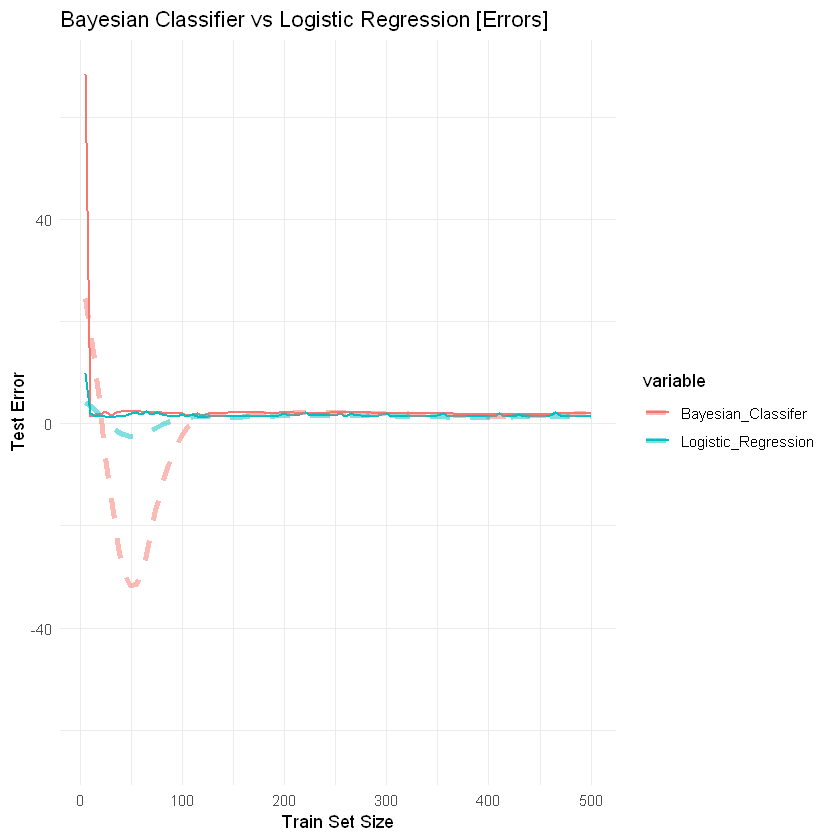

In [48]:
er_test.m <- melt(as.data.frame(er_test), id='Set_Size')
ggplot(data=er_test.m, aes(x = Set_Size, y = value, color=variable)) + geom_line(size=.75) + 
  geom_line(stat="smooth",method = "loess",formula = y ~ poly(x, 2),
              size = 1.5,
              linetype ="dashed",
              alpha = 0.5)+
        labs(x = "Train Set Size", y = "Test Error") +  theme_minimal() + ggtitle("Bayesian Classifier vs Logistic Regression [Errors]")

We can notice that the graphs extremely left skewed and that is because of an outlier as the batch size of 5 doesn't generate a meaningful co-variance matrix and hence interferes with the error values and final plot. Thus, in the next step, we can create a subset of the dataframe excluding the first row and use it for further plotting which will give a better undertstanding of the plot and derive a meaningful conclusion.

In [45]:
# Subsetting excluding the first row
sub <- er_test[-1,]

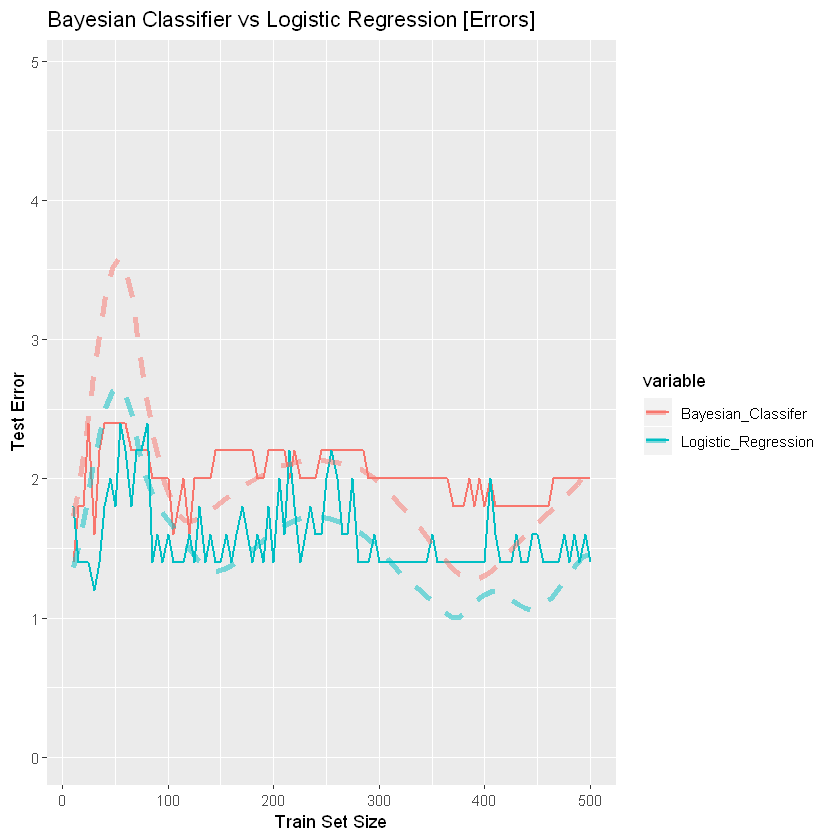

In [44]:
sub.m <- melt(as.data.frame(sub), id='Set_Size')
ggplot(data=sub.m, aes(x = Set_Size, y = value, color=variable)) + 
 geom_line(size=.75) + 
  geom_line(stat="smooth",method = "loess",formula = y ~ poly(x, 2),
              size = 1.5,
              linetype ="dashed",
              alpha = 0.5)+ 
        labs(x = "Train Set Size", y = "Test Error") + ggtitle("Bayesian Classifier vs Logistic Regression [Errors]")

> ##### 3. Explain your observations in your Jupyter Notebook file.:

> a. What does happen for each classifier when the number of training data points is increased? 
> * When the training points are increased, the test and training error for each classifier decreases as we can see from the graph above where the lowest error rates are observed between 350-400. It shows a gradual increase in the trend according to the smoothing line, but on observing the actual plot, we can observe that the error rate remains steady.
 
> b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big? 
> * Small - Bayesian, Large - Logistic, because Bayesian converges quickly, since for small datasets, Bayesian classifier converges quickly
 
> c. Justify your observations in previous questions (III.a & III.b) by providing some speculations and possible reasons.  
> * Although we see that on a general trend logistic regression performs better with lesser error rates, in smaller datasets, Basyesian Classifer can provide a better result as observed in the intial ranges between 0-150.